In [1]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import librosa.display
import scipy
import pickle
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "IPAexGothic"

# 音声認識の基本用語

- サンプリングレート：1秒間に計測するデータ点の個数
- アップサンプリング：元データから連続波形を予測して、指定するデータ点数だけデータを増やすこと。
- ダウンサンプリング：元データから連続波形を予測して、それに従ってデータ点を間引く作業


## 関係式

$$
f = \frac{1}{T} 
$$

- サンプリングレートを落とすと、高周波のデータが見えなくなる。人間が喋っている音声には8kHzほどのデータが含まれるので、サンプリング定理よりその倍の16kHzでサンプリングしていればオッケーらしい

# 音声認識の特徴量

## フーリエ変換

### STFT (short time fourier transform; 短時間フーリエ変換)

信号に対して窓関数をずらしながら掛けて周波数成分を求める解析のこと。`librosa.stft` は複素行列を返す。
librosaのstftのデフォルト値は以下の通り

- n_fft = 20048
- hop_length = win_length//4
- win_length = n_fft
- window = "hann" ハニング窓

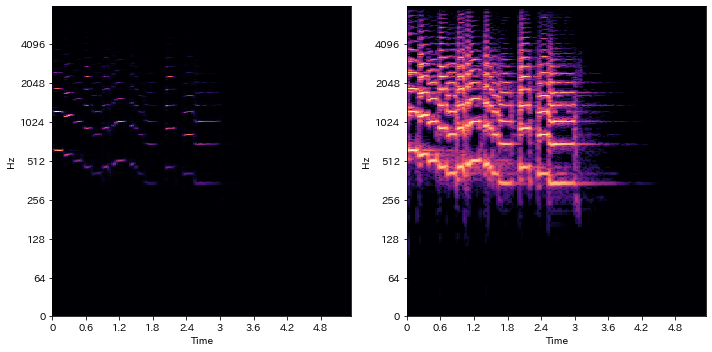

In [4]:
y, sr = librosa.load(librosa.ex("trumpet"), sr = 16000)

fig, ax= plt.subplots(1,2, figsize=(10, 5))

spec = np.abs(librosa.stft(y, hop_length=512))
spec_db = librosa.amplitude_to_db(spec, ref=np.max) # 振幅-->dB 変換

librosa.display.specshow(spec, sr=sr, x_axis='time', y_axis='log', ax=ax[0])
librosa.display.specshow(spec_db, sr=sr, x_axis='time', y_axis='log', ax=ax[1])

plt.tight_layout()
plt.show()

### 高速フーリエ変換（FTT)

離散フーリエ変換の計算時間を減らすために、一般的なルゴリズムでは高速フーリエ変換（Fast Fourier Transform)が行われる。長さが$N$の波形$x(n)$ に対する離散フーリエ変換は以下の式で記述される。

$$
X_N(k) = \sum_{n=0}^{N-1}x(n)e^{-i2\pi \frac{nk}{N}},~~0\leq k<N
$$

$x_N(n)$ は周期$N$の周期的信号、$k$は周波数、$n$はデータ点を表す。この $X_N(k)$ は複素スペクトルと呼ばれる複素数である。音の大きさを表す音声のパワースペクトルは以下の式で定義される。

$$
S_k = \frac{1}{N}|X_N(k)|^2
$$

このパワースペクトルは$k$について$N/2$に対して対称な形を取る。


#### numpy.fft.fft

In [5]:
y, sr = librosa.load(librosa.ex("trumpet"), sr = 16000)
x_fft = np.fft.fft(y)
x_fft

array([ 0.00287275-1.06581410e-14j, -0.00578618+2.03701779e-03j,
        0.00925575+7.61473401e-03j, ...,  0.00458069+8.57583068e-03j,
        0.00925575-7.61473401e-03j, -0.00578618-2.03701779e-03j])

/Users/takeda/.pyenv/versions/3.7.3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


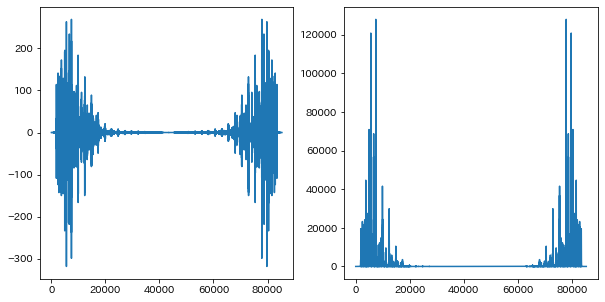

len(y) =  85335


In [6]:
y, sr = librosa.load(librosa.ex("trumpet"), sr = 16000)
X = np.fft.fft(y)

fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].plot(X)
ax[1].plot(np.abs(X)**2)

plt.show()

print("len(y) = ", len(y))

上記の例で分かるように、長さ24000の真ん中12000で折返しの形になっていることが分かる。

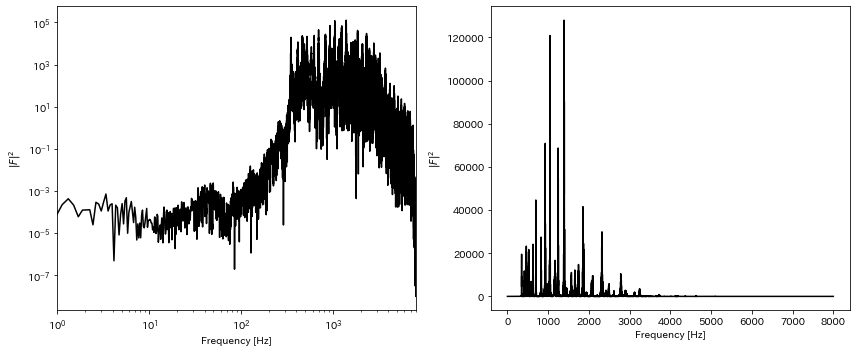

In [7]:
F = np.fft.fft(y)
freq = np.fft.fftfreq(y.size, d=1./sr)

fig = plt.figure(figsize=(12,5))

ax = fig.add_subplot(1,2,1)

ax.plot(freq[0: F.size//2], np.abs(F[0:F.size//2])**2, color="black")

ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("$|F|^{2}$")
ax.set_xlim(1, 8000)
ax.set_xscale("log")
ax.set_yscale("log")

ax = fig.add_subplot(1,2,2)
ax.plot(freq[0: F.size//2], np.abs(F[0:F.size//2])**2, color="black")
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("$|F|^{2}$")

plt.tight_layout()
plt.show()

## 音圧

音の物理的な強度は音の圧力 $p$ として表され、単位は圧力と同じ Pa である。その音圧 $p$ を図る尺度として音圧レベル（$L_p$）が以下の式で定義される。この音圧レベルの単位はデシベル（dB）である。

$$
L_p = 10\times \log_{10}\frac{p^2}{p_0^2} = 20 \times \log_{10}\frac{p}{p_0},~~\text{where}~p_0=20\times 10^6~\text{Pa}
$$

ここでの $p_0$ は人間に聞こえる最も小さい音の音圧に対応していて、その音の何倍かを表す尺度になっている。

## メル尺度

- 人間の音高近くに基づいた、実験的に決められた尺度
    - 人間は線形スケールで周波数を知覚せず、低周波数の違いを検出するのが得意である
    - 500, 1000Hzの違いは分かっても10000Hzと10500Hzの違いはわからない
- 1000Hzを基準として、その$n$倍に知覚される周波数を $n\times 1000$メルと表記する

$$
m = \frac{1000}{\log_{10}2}\log_{10}\left(\frac{f}{1000}+1 \right)
$$

- 周波数 $f$ の関数としてメル尺度が定義される

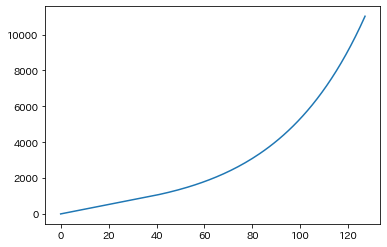

In [6]:
plt.plot(librosa.mel_frequencies())

## ケプストラム

生波形をフーリエ変換して周波数スペクトルに変換し、その後に周波数軸で対数を取ったものを逆フーリエ変換して時間に戻す。対数スペクトル領域で見ると、微細な構造と包絡構造が分離できるのが嬉しいらしい。

## メルフィルタバンク

メル周波数領域で等間隔なバンドパスフィルタ（特定周波数帯のみを抽出するフィルタ）のこと。個別の周波数ビンの値をグループ化する処理に相当する。

- sr : サンプリングレート
- n_fft : STFTのときの1フレーム中のデータ点数。もちろんSTFTしたときのものと合わせる必要がある。

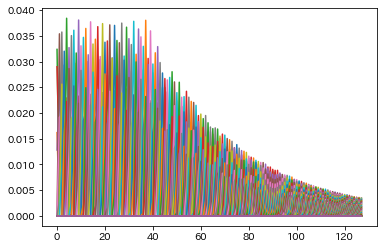

In [7]:
fig, ax = plt.subplots()
melfb = librosa.filters.mel(sr=22050, n_fft=2048)
plt.plot(melfb)
plt.show()

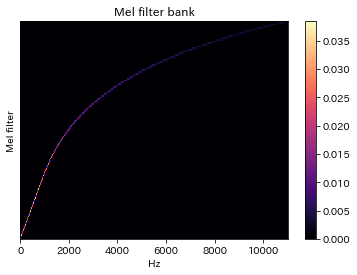

In [8]:
fig, ax = plt.subplots()

melfb = librosa.filters.mel(sr=22050, n_fft=2048)
img = librosa.display.specshow(melfb, x_axis='linear', ax=ax)

ax.set(ylabel='Mel filter', title='Mel filter bank')
fig.colorbar(img, ax=ax)
plt.show()

In [9]:
melfb = librosa.filters.mel(sr=22050, n_fft=2048)
melfb.shape

(128, 1025)

## MFCC (メル周波数ケプストラム係数）

メル周波数領域でケプストラムを求めることであり、係数という名前がついているが、計算過程もMFCCと呼ばれたりする。

- https://ismir2000.ismir.net/papers/logan_paper.pdf

手順：

1. STFTを行う
    - 音声データをフレームに分割する
    - window関数を適応、離散フーリ変換をして周波数スペクトルを得る
2. 対数を取る
3. メルフィルタバンクを掛ける
    - メル周波数で均等になるように変換する
4. 離散コサイン変換（Dicrete Cosine Transform）をする

上記の「フレーム分割→周波数スペクトルを得る」まではSTFTで実現される。変換結果は通常、絶対値の二乗を取ってパワースペクトルに変換する。位相情報が落ち振幅情報だけが残るが、これだけで十分だとのこと。

### STFT, 周波数成分の対数表示

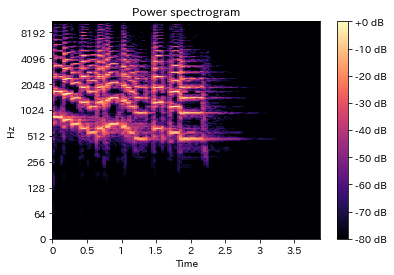

In [8]:
y, sr = librosa.load(librosa.ex("trumpet"), sr = 16000)

# STFT 
y_stft = librosa.stft(y, n_fft=2048)
# --> amplitude
S = np.abs(y_stft)
# --> db
S_db = librosa.amplitude_to_db(S, ref=np.max)

fig, ax = plt.subplots()
img = librosa.display.specshow(S_db, y_axis='log', x_axis='time', ax=ax)
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

plt.show()

### メルフィルタバンクを掛ける

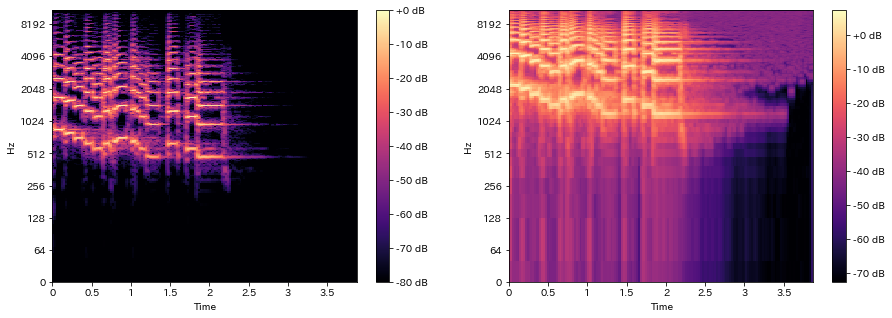

In [9]:
# メルフィルタバンクの作成
mel_filter = librosa.filters.mel(sr, n_fft=2048)
# フィルタを掛ける
melspec = np.dot(mel_filter, S)
melspec_db = librosa.power_to_db(melspec)

fig, ax = plt.subplots(1,2, figsize=(15, 5))

img = librosa.display.specshow(S_db, ax=ax[0], x_axis="time", y_axis="log")
fig.colorbar(img, ax=ax[0], format='%+2.f dB')

img = librosa.display.specshow(melspec_db, ax=ax[1], x_axis="time", y_axis="log")
fig.colorbar(img, ax=ax[1], format='%+2.f dB')

plt.show()

## 離散コサイン変換をする

メルフィルタバンクを掛けたスペクトル（メルスペクトル）を時間信号のように捉えて、逆離散フーリエ変換をすることでケプストラムが求まる。計算するとこの逆離散フーリエ変換は逆離散コサイン変換で表すことができる。

In [10]:
from scipy import fftpack

n_mfcc=20 #後で見る librosa.mfcc で20が使用されているので、ここで統一した
log_melspec_db = librosa.power_to_db(np.log(melspec))
mfcc = scipy.fftpack.dct(log_melspec_db, type=2, norm="ortho", axis=-1)[:n_mfcc].T

## librosaの関数を使用する

手で計算したものと、librosaの関数とを比較する。（未完成）

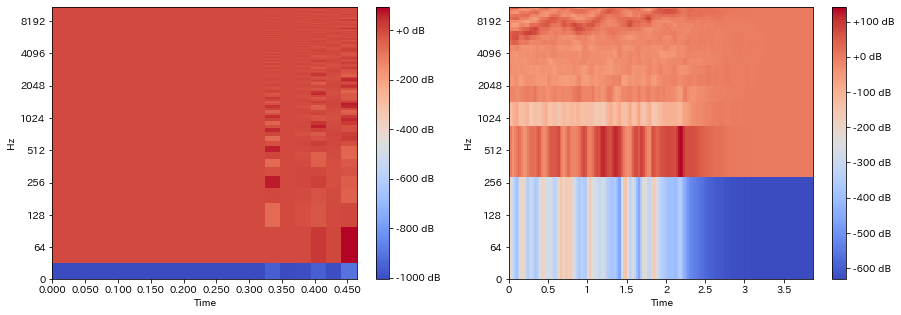

In [11]:
mfccs = librosa.feature.mfcc(y, sr)

fig, ax = plt.subplots(1,2, figsize=(15, 5))

img = librosa.display.specshow(mfcc, ax=ax[0], x_axis="time", y_axis="log")
fig.colorbar(img, ax=ax[0], format='%+2.f dB')

img = librosa.display.specshow(mfccs, ax=ax[1], x_axis="time", y_axis="log")
fig.colorbar(img, ax=ax[1], format='%+2.f dB')

## 係数として使用するためには

STFTの出力のままでは周波数と時間の関数となっていて、「係数」として使用するのは厳しい。よく使用されていそうなのは、周波数方向に射影して（時間方向で和を取って）、その平均を各周波数帯のMFCCとする手法である。こうすればざっくりとした違いは求まるのでは？と思っているが、使えるのだろうか。

## （注）DNNにおけるMFCC

とあるQiitaによると、MFCCは使用せず最後の離散コサイン変換（DCT）を省いた、メルフィルタバンクを掛けたもの（メルスペクトラム）が入力として使用されるようである。MFCCまでしてしまうと、どうやらDNNにとっては必要な情報が欠けてしまうらしい。その一方で、MFCCは従来の分類器では重要な特徴量の一つであるようである。

- https://arxiv.org/abs/1905.00078

には

> Whereas MFCCs are the most common representation in
traditional audio signal processing, log-mel spectrograms are
the dominant feature in deep learning, followed by raw
waveforms or complex spectrograms.

と書いている。ふーん

## メルスペクトログラム

`librosa.feature.melspectrogram` で、メル尺度のスペクトログラムが計算できる。

- STFTをおこなう → $|S|^2$ にして振幅の情報とする
- メルフィルタバンクを掛ける

の操作を行ったものをメルスペクトログラムと呼ぶ。なので基本的にはSTFTの延長線上の操作を行っている。

In [12]:
y, sr = librosa.load(librosa.ex('trumpet'))
array = librosa.feature.melspectrogram(y=y, sr=sr)
array.shape

(128, 230)

返ってくるデータは 周波数 × 時間 の次元を持っている。 デフォルトで、周波数成分は128次元に固定されており（これはメルフィルタバンクの作り方に由来する。ここをいじるなら、`librosa.filters.mel` の n_mels をいじること。

なので、メルフィルタバンクをかければどんな周波数だろうが次元を固定することができる → 扱いやすい